# Table of Contents

1. **Load Libraries and Imports**
   - Standard Libraries
   - PyTorch Libraries
   - Libraries for Image Processing and Model Summaries
   - Custom Dataset Preparation Function

2. **Load Dataset Components**
   - Set Random Seed for Reproducibility
   - Define Dataset Directory
   - Load Train and Validation Datasets
   - Display Dataset Shapes

3. **Dataset Loader with Augmentations**
   - Custom Transform Classes
     - Add Gaussian Noise
     - Color Jitter
     - Random Rotation
   - Define Transformations for Training and Validation Datasets
   - Load Train and Validation Datasets with Transformations
   - Create DataLoader for Batching
   - Visualize Samples from DataLoader

4. **Confirm Normalization for Images and Bounding Boxes**
   - Check Bounding Boxes
   - Check Pixel Normalization

5. **Model Definition**
   - Define the Simple VGG Model
   - Summary Model Display

6. **Modeling**
   - DataLoaders for Training and Validation
   - Model, Loss Functions, and Optimizer Initialization
   - Learning Rate Scheduler
   - Directory Structure for Saving Results
   - Training Loop with Logging
   - Validation Loop with Logging
   - Save Best Model
   - Metrics DataFrame and CSV Export

7. **Get Predictions and Bounding Boxes**
   - Load Saved Model Weights
   - Evaluate Model on Validation Data
   - Retrieve Confidence Scores and Bounding Boxes

8. **Comparison and Metrics Calculation**
   - Display Comparison Table for Random Images
   - Plot Images with Bounding Boxes
   - Compute and Display Metrics
   - Confusion Matrices and Classification Reports

9. **Visualizing Feature Maps and Filters**
   - Visualizing the Feature Maps Produced by a CNN Model
   - Visualizing the Filters of the First Convolutional Layer

## 1. Load Libraries and Imports

In [1]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
import torch.nn.functional as F

# Libraries for image processing and model summaries
from torchvision import transforms  # Data transformations
from torchinfo import summary  # Model architecture summaries

# Custom dataset preparation
from datasets import CustomImageDataset2

# Scikit-learn metrics for evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

## 2. Load Dataset Components

Added random seed for repeatability purposes.

In [2]:
# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmarks for reproducibility

set_random_seed(42) 

# Define the dataset directory
DATA_DIR = 'pytorch_datasets'

# Function to load dataset components
def load_dataset(dataset_name, data_dir=DATA_DIR):
    dataset = {}
    for component in ['images', 'labels', 'bounding_boxes']:
        dataset[component] = np.load(os.path.join(data_dir, f'{dataset_name}_{component}.npy'))
    return dataset['images'], dataset['labels'], dataset['bounding_boxes']

# Load train and validation datasets
train_images, train_labels, train_bounding_boxes = load_dataset('train_dataset')
val_images, val_labels, val_bounding_boxes = load_dataset('val_dataset')

# Display dataset shapes
def print_dataset_shapes(images, labels, bboxes, dataset_type="Train"):
    print(f"{dataset_type} Dataset: Images: {images.shape}, Labels: {labels.shape}, Bounding Boxes: {bboxes.shape}")

print_dataset_shapes(train_images, train_labels, train_bounding_boxes, "Train")
print_dataset_shapes(val_images, val_labels, val_bounding_boxes, "Validation")

Train Dataset: Images: (7844, 224, 224, 3), Labels: (7844,), Bounding Boxes: (7844, 4)
Validation Dataset: Images: (881, 224, 224, 3), Labels: (881,), Bounding Boxes: (881, 4)


## 3. Dataset Loader with Augmentations

- **Label Encoding and Data Augmentation**: Unique object labels are mapped to numerical values for easier processing. Custom transformations are introduced, including Gaussian noise, color jitter, and random rotation, to enhance dataset diversity and improve model robustness.

- **Transformations for Training and Validation**: Two sets of transformations are defined—one for training that includes resizing and augmentations, and another for validation that focuses on resizing and tensor conversion, ensuring a consistent evaluation environment.

- **DataLoader Creation and Sample Visualization**: DataLoaders are created for efficient batching during training and validation. Sample visualization from the training DataLoader verifies that images and labels are correctly aligned and ready for model training.

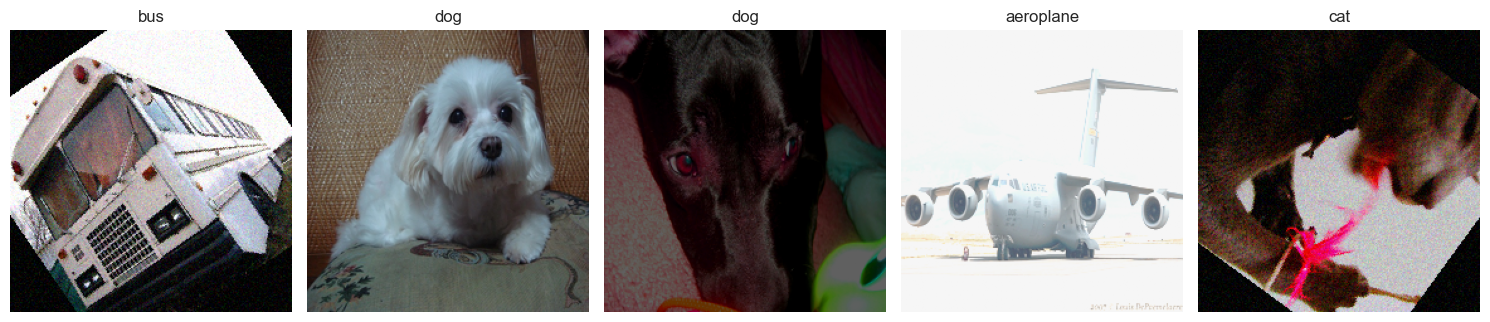

In [3]:

# Label encoding for the dataset
unique_labels = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

# Custom transform to add Gaussian noise with a probability
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if random.random() < self.p:
            noise = torch.randn(tensor.size()) * self.std + self.mean
            tensor = tensor + noise
            return torch.clamp(tensor, 0, 1)
        return tensor

# Custom transform to apply ColorJitter with a probability
class ConditionalColorJitter:
    def __init__(self, brightness_range=(0.5, 1.5), contrast_range=(0.5, 1.5),
                 saturation_range=(0.5, 1.5), hue_range=(0, 0.1), p=0.5):
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
        self.saturation_range = saturation_range
        self.hue_range = hue_range
        self.p = p

    def __call__(self, tensor):
        if random.random() < self.p:
            color_jitter = transforms.ColorJitter(
                brightness=random.uniform(*self.brightness_range),
                contrast=random.uniform(*self.contrast_range),
                saturation=random.uniform(*self.saturation_range),
                hue=random.uniform(*self.hue_range)
            )
            return color_jitter(tensor)
        return tensor

# Custom transform to apply random rotation with a probability
class ConditionalRandomRotation:
    def __init__(self, degrees=(-45, 45), p=0.25):
        self.degrees = degrees
        self.p = p
        self.rotation_transform = transforms.RandomRotation(degrees)

    def __call__(self, tensor):
        return self.rotation_transform(tensor) if random.random() < self.p else tensor

# Define transformations for training and validation datasets
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    ConditionalRandomRotation(degrees=(-45, 45), p=0.50),
    ConditionalColorJitter(brightness_range=(0.6, 1.4), contrast_range=(0.8, 1.2),
                           saturation_range=(0.7, 1.3), hue_range=(0, 0.2), p=0.25),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.05, p=0.50)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load train and validation datasets with the defined transformations
train_ds = CustomImageDataset2(train_images, train_labels, train_bounding_boxes,
                               label_mapping=label_to_id, transform=train_transform)
val_ds = CustomImageDataset2(val_images, val_labels, val_bounding_boxes,
                             label_mapping=label_to_id, transform=val_transform)

# Create DataLoader for batching
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Function to visualize samples from DataLoader with label names
def visualize_samples(loader, num_samples=5):
    """
    Visualize a few samples from the DataLoader, showing label names.
    
    Parameters:
    - loader: DataLoader object containing the dataset.
    - num_samples: Number of samples to visualize.
    """
    plt.figure(figsize=(15, 8))
    
    for i in range(num_samples):
        sample_idx = random.randint(0, len(loader.dataset) - 1)
        image, label_id, bbox = loader.dataset[sample_idx]
        
        # Convert the label_id back to the label name using the label_to_id dictionary
        label_name = unique_labels[label_id]
        
        # Prepare the image for plotting
        image = image.permute(1, 2, 0).numpy()  # Convert tensor (C, H, W) to (H, W, C)
        image = np.clip(image, 0, 1)  # Clip values to range [0, 1]
        
        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        
        # Set the title with the label name
        plt.title(f"{label_name}")

    plt.tight_layout()
    plt.show()

# Visualize a few samples from the training DataLoader with label names
visualize_samples(train_loader, num_samples=5)

## 4. Confirm Normalization for Images and Bounding Boxes

In [4]:
# Function to check bounding boxes
def check_bounding_boxes(dataset, sample_idx):
    image, label_id, bbox = dataset[sample_idx]
    h, w = image.shape[1], image.shape[2]  # Get height and width from image shape

    # Convert bbox to pixel coordinates
    bbox_pixel = bbox * np.array([w, h, w, h])
    
    print(f"Sample {sample_idx} - Original Bounding Box (x_min, y_min, x_max, y_max): {bbox_pixel}")  # Print bbox in pixel coordinates
    print(f"Sample {sample_idx} - Normalized Bounding Box: {bbox}")  # Print normalized bbox

# Check bounding boxes for a specific sample
check_bounding_boxes(train_ds, sample_idx=0)

# Function to check pixel normalization
def check_pixel_normalization(dataset, sample_idx):
    image, label_id, bbox = dataset[sample_idx]
    print(f"Sample {sample_idx} - Min Pixel Value: {image.min().item()}, Max Pixel Value: {image.max().item()}")

# Check pixel normalization for a specific sample
check_pixel_normalization(train_ds, sample_idx=0)

Sample 0 - Original Bounding Box (x_min, y_min, x_max, y_max): tensor([ 44.8000,  57.9413, 200.2560, 182.1867], dtype=torch.float64)
Sample 0 - Normalized Bounding Box: tensor([0.2000, 0.2587, 0.8940, 0.8133])
Sample 0 - Min Pixel Value: 0.0, Max Pixel Value: 1.0


## 5. Model Definition

- **Architecture Overview**: The `SimpleVGG` model consists of multiple convolutional blocks with increasing channel depth, followed by global average pooling. Each block includes convolution, batch normalization, ReLU activation, and max pooling to progressively extract features from the input images.

- **Output Layers**: The model has two output heads: one for classification, which predicts class probabilities for a specified number of classes, and another for bounding box regression, which predicts the coordinates of bounding boxes for detected objects.

- **Forward Pass**: The forward method defines how input images flow through the network, applying the various layers and transformations. The final output includes both classification results and bounding box predictions, facilitating multi-task learning.

In [5]:
class SimpleVGG(nn.Module):
    def __init__(self, num_classes):
        super(SimpleVGG, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv5 = nn.Conv2d(256, 512, kernel_size=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 6
        self.conv6 = nn.Conv2d(512, 512, kernel_size=2, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=2, padding=1)
        self.bn7 = nn.BatchNorm2d(1024)
        self.pool7 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.fc_bbox = nn.Linear(1024, 4)  # Bounding box prediction

    def forward(self, x):
        # Forward pass through conv layers and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool6(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool7(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Shared fully connected layer
        x = F.relu(self.fc1(x))

        # Output: classification and bounding box
        class_output = self.fc2(x)
        bbox_output = self.fc_bbox(x)

        return class_output, bbox_output


# Example usage
num_classes = 20  # Replace with the actual number of classes
model = SimpleVGG(num_classes=num_classes)

In [6]:
# Display the model summary in the console
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleVGG                                [1, 20]                   --
├─Conv2d: 1-1                            [1, 32, 222, 222]         2,432
├─BatchNorm2d: 1-2                       [1, 32, 222, 222]         64
├─MaxPool2d: 1-3                         [1, 32, 111, 111]         --
├─Conv2d: 1-4                            [1, 64, 111, 111]         18,496
├─BatchNorm2d: 1-5                       [1, 64, 111, 111]         128
├─MaxPool2d: 1-6                         [1, 64, 55, 55]           --
├─Conv2d: 1-7                            [1, 128, 56, 56]          32,896
├─BatchNorm2d: 1-8                       [1, 128, 56, 56]          256
├─MaxPool2d: 1-9                         [1, 128, 28, 28]          --
├─Conv2d: 1-10                           [1, 256, 29, 29]          131,328
├─BatchNorm2d: 1-11                      [1, 256, 29, 29]          512
├─MaxPool2d: 1-12                        [1, 256, 14, 14]         

## 6. **Modeling**
   - DataLoaders for Training and Validation
   - Model, Loss Functions, and Optimizer Initialization
   - Learning Rate Scheduler
   - Directory Structure for Saving Results
   - Training Loop with Logging
   - Validation Loop with Logging
   - Save Best Model
   - Metrics DataFrame and CSV Export

In [7]:
# Hyperparameters
num_epochs = 5  # Number of epochs for training
batch_size = 64  # Number of samples per batch
initial_learning_rate = 0.001  # Initial learning rate

# Assuming train_ds and val_ds are defined
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Initialize model, loss functions, and optimizer
model = SimpleVGG(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
bbox_criterion = nn.MSELoss()  # MSE loss function for bounding boxes
optimizer = torch.optim.Adam(
    [{'params': model.fc2.parameters()},  # Trainable parameters for classification
     {'params': model.fc_bbox.parameters()}],  # Trainable parameters for bounding box regression
    lr=initial_learning_rate
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# Function to get the next run number
def get_next_run_number(parent_dir):
    existing_runs = [
        d for d in os.listdir(parent_dir) 
        if d.startswith('run_') and os.path.isdir(os.path.join(parent_dir, d))
    ]
    return max([int(run.split('_')[1]) for run in existing_runs], default=0) + 1

# Create a parent folder for saving all results
parent_results_dir = 'pytorch_model_results'
os.makedirs(parent_results_dir, exist_ok=True)

# Determine the next run number
next_run_number = get_next_run_number(parent_results_dir)

# Create a new folder for saving this run
results_dir = os.path.join(parent_results_dir, f'run_{next_run_number}_')
os.makedirs(results_dir, exist_ok=True)

# Create a unique log directory for TensorBoard
log_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # Create a timestamp
writer = SummaryWriter(log_dir=os.path.join('logs', f'run_{next_run_number}_{log_time}'))  # Include timestamp in directory name

# Move model to the appropriate device (GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Initialize variable to track the best validation accuracy
best_val_accuracy = 0.0

# Initialize lists to store metrics for each epoch
train_losses, train_accuracies, train_bbox_mses = [], [], []
val_losses, val_accuracies, val_bbox_mses = [], [], []

# Start training process
print("Starting the training process...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_bbox_loss, correct, total = 0.0, 0.0, 0, 0

    for batch_idx, (images, labels, bboxes) in enumerate(train_loader):
        images, labels, bboxes = images.to(device).float(), labels.to(device).long(), bboxes.to(device).float()

        # Forward pass
        class_outputs, bbox_outputs = model(images)

        # Calculate losses
        cls_loss = criterion(class_outputs, labels)
        bbox_loss = bbox_criterion(bbox_outputs, bboxes)
        loss = cls_loss + bbox_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for logging
        running_loss += loss.item()
        running_bbox_loss += bbox_loss.item()

        # Calculate accuracy
        _, predicted = torch.max(class_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress for each batch
        if (batch_idx + 1) % (len(train_loader) // 10) == 0:  # Print every 10% of the epoch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {running_loss / (batch_idx + 1):.4f}, '
                  f'BBox MSE Loss: {running_bbox_loss / (batch_idx + 1):.4f}, '
                  f'Accuracy: {100 * correct / total:.2f}%')

    # Average metrics for the epoch
    avg_loss = running_loss / len(train_loader)
    avg_bbox_loss = running_bbox_loss / len(train_loader)
    accuracy = 100 * correct / total

    # Append training metrics to lists
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    train_bbox_mses.append(avg_bbox_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, '
          f'BBox MSE Loss: {avg_bbox_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_running_bbox_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images, labels, bboxes = images.to(device).float(), labels.to(device).long(), bboxes.to(device).float()

            class_outputs, bbox_outputs = model(images)
            _, predicted = torch.max(class_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_bbox_loss = bbox_criterion(bbox_outputs, bboxes)
            val_running_bbox_loss += val_bbox_loss.item()

    val_accuracy = 100 * correct / total
    avg_val_bbox_loss = val_running_bbox_loss / len(val_loader)

    # Append validation metrics to lists
    val_losses.append(avg_val_bbox_loss)
    val_accuracies.append(val_accuracy)
    val_bbox_mses.append(avg_val_bbox_loss)

    print(f'Validation Accuracy: {val_accuracy:.2f}%, BBox MSE Loss: {avg_val_bbox_loss:.4f}')

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('BBox MSE Loss/train', avg_bbox_loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    writer.add_scalar('Loss/val', avg_val_bbox_loss, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    # Save model if the validation accuracy is the best we've seen so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = os.path.join(results_dir, f'model_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_path)
        print(f'Model saved to {model_path} with validation accuracy: {best_val_accuracy:.2f}%')

    # Step the scheduler
    scheduler.step(val_accuracy)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Train BBox MSE': train_bbox_mses,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val BBox MSE': val_bbox_mses
})

# Save the metrics to a CSV file
metrics_csv_path = os.path.join(results_dir, 'training_metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f'Training metrics saved to {metrics_csv_path}')

# Close the writer when done
writer.close()
print("Training complete.")

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting the training process...
Epoch [1/5], Batch [12/123], Loss: 2.9271, BBox MSE Loss: 0.1290, Accuracy: 10.42%
Epoch [1/5], Batch [24/123], Loss: 2.8388, BBox MSE Loss: 0.0892, Accuracy: 13.09%
Epoch [1/5], Batch [36/123], Loss: 2.7931, BBox MSE Loss: 0.0725, Accuracy: 14.76%
Epoch [1/5], Batch [48/123], Loss: 2.7584, BBox MSE Loss: 0.0636, Accuracy: 16.18%
Epoch [1/5], Batch [60/123], Loss: 2.7419, BBox MSE Loss: 0.0578, Accuracy: 16.59%
Epoch [1/5], Batch [72/123], Loss: 2.7257, BBox MSE Loss: 0.0539, Accuracy: 16.91%
Epoch [1/5], Batch [84/123], Loss: 2.7027, BBox MSE Loss: 0.0506, Accuracy: 17.73%
Epoch [1/5], Batch [96/123], Loss: 2.6853, BBox MSE Loss: 0.0484, Accuracy: 17.82%
Epoch [1/5], Batch [108/123], Loss: 2.6718, BBox MSE Loss: 0.0465, Accuracy: 18.27%
Epoch [1/5], Batch [120/123], Loss: 2.6573, BBox MSE Loss: 0.0449, Accuracy: 18.48%
Epoch [1/5], Loss: 2.6561, BBox MSE Loss: 0.0447, Accuracy: 18.45%
Validation Accuracy: 24.06%, BBox MSE Loss: 0.0310
Model saved to py

### Training Metrics Saving

In [8]:
# Ensure all lists are of the same length by truncating or padding
min_length = min(len(train_losses), len(train_accuracies), len(train_bbox_mses), len(val_losses), len(val_accuracies), len(val_bbox_mses))

# Truncate the lists to the minimum length
train_losses = train_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
train_bbox_mses = train_bbox_mses[:min_length]
val_losses = val_losses[:min_length]
val_accuracies = val_accuracies[:min_length]
val_bbox_mses = val_bbox_mses[:min_length]

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Epoch': range(1, min_length + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Train BBox MSE': train_bbox_mses,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val BBox MSE': val_bbox_mses
})

# Save the metrics to a CSV file
metrics_csv_path = os.path.join(results_dir, 'training_metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f'Training metrics saved to {metrics_csv_path}')

# Close the writer when done
writer.close()
print("Training complete.")

Training metrics saved to pytorch_model_results/run_20241099_/training_metrics.csv
Training complete.


In [9]:
from torchinfo import summary

# Generate the model summary
model_summary = summary(model, input_size=(1, 3, 224, 224), verbose=2)

# Saving the summary directly to a text file in the specified directory
summary_file_path = os.path.join(results_dir, 'model_summary.txt')  # Create the full file path

with open(summary_file_path, 'w') as f:
    f.write("Model Summary:\n\n")  # Optional header
    f.write(str(model_summary))  # Write the summary to the file

Layer (type:depth-idx)                   Output Shape              Param #
SimpleVGG                                [1, 20]                   --
├─Conv2d: 1-1                            [1, 32, 222, 222]         2,432
│    └─weight                                                      ├─2,400
│    └─bias                                                        └─32
├─BatchNorm2d: 1-2                       [1, 32, 222, 222]         64
│    └─weight                                                      ├─32
│    └─bias                                                        └─32
├─MaxPool2d: 1-3                         [1, 32, 111, 111]         --
├─Conv2d: 1-4                            [1, 64, 111, 111]         18,496
│    └─weight                                                      ├─18,432
│    └─bias                                                        └─64
├─BatchNorm2d: 1-5                       [1, 64, 111, 111]         128
│    └─weight                                             

In [10]:
stop

NameError: name 'stop' is not defined

## 7. Get Predictions and Bounding Boxes

In [11]:
def get_predictions(model, data_loader, device):
    """Get predictions and bounding boxes from the model."""
    model.eval()
    all_labels, all_predicted = [], []
    all_true_boxes, all_predicted_boxes = [], []
    all_confidences, images = [], []

    with torch.no_grad():
        for batch_images, batch_labels, batch_true_boxes in data_loader:
            batch_images = batch_images.to(device)
            outputs, predicted_boxes = model(batch_images)  # Model returns both predictions and bbox

            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            _, predicted_classes = torch.max(probabilities.data, 1)

            # Move data to CPU and convert to numpy
            all_labels.extend(batch_labels.numpy())
            all_predicted.extend(predicted_classes.cpu().numpy())
            all_true_boxes.extend(batch_true_boxes.numpy().tolist())
            all_predicted_boxes.extend(predicted_boxes.cpu().numpy().tolist())
            images.append(batch_images.cpu())

            # Get confidence scores for the predicted classes
            confidence_scores = probabilities[range(len(probabilities)), predicted_classes].cpu().numpy()
            all_confidences.extend(confidence_scores.tolist())

    # Concatenate images for visualization later
    all_images = torch.cat(images)

    return all_images, all_labels, all_predicted, all_true_boxes, all_predicted_boxes, all_confidences

# Load the saved model weights
model_path = '/Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_/model_epoch_5.pth'  # Specify the correct path to your saved model
model.load_state_dict(torch.load(model_path))
model.to(device) 
model.eval()  # Set the model to evaluation mode

# Get predictions
all_images, all_labels, all_predicted, all_true_boxes, all_predicted_boxes, all_confidences = get_predictions(model, val_loader, device)

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_97754/373459490.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

## 8. Comparison and Metrics Calculation

In [12]:
# Unique labels
unique_labels = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def get_comparison_data(true_boxes, pred_boxes, true_labels, pred_labels, confidences, img_size=224, num_images=25):
    """Display a comparison table for random images and return relevant data."""
    # Get random indices for the images
    random_indices = random.sample(range(len(true_boxes)), num_images)

    # Prepare data for the DataFrame
    data = [
        {
            'Image Index': idx,
            'True Box': ", ".join(f"{value * img_size:.2f}" for value in true_boxes[idx]),
            'True Label': unique_labels[true_labels[idx]],  # True label name
            'Predicted Box': ", ".join(f"{value * img_size:.2f}" for value in pred_boxes[idx]),
            'Predicted Label': unique_labels[pred_labels[idx]],  # Predicted label name
            'Confidence Score': f"{confidences[idx]:.2f}"  # Confidence score
        }
        for idx in random_indices
    ]

    # Create DataFrame
    comparison_df = pd.DataFrame(data)

    # Display the comparison table using tabulate for a better format
    print(tabulate(comparison_df, headers='keys', tablefmt='pretty', showindex=False))

    return data

# Assuming you have confidence scores available from predictions
# Get comparison data for 5 random images
comparison_data = get_comparison_data(all_true_boxes, all_predicted_boxes, all_labels, all_predicted, all_confidences)

# Extract relevant data for plotting
image_indices = [entry['Image Index'] for entry in comparison_data]
true_boxes = [entry['True Box'] for entry in comparison_data]
true_labels = [entry['True Label'] for entry in comparison_data]
predicted_boxes = [entry['Predicted Box'] for entry in comparison_data]
predicted_labels = [entry['Predicted Label'] for entry in comparison_data]
confidence_scores = [entry['Confidence Score'] for entry in comparison_data]  # Confidence scores for plotting

+-------------+-------------------------------+------------+------------------------------+-----------------+------------------+
| Image Index |           True Box            | True Label |        Predicted Box         | Predicted Label | Confidence Score |
+-------------+-------------------------------+------------+------------------------------+-----------------+------------------+
|     848     |  0.90, 81.24, 220.86, 224.00  |    sofa    | 37.27, 41.59, 188.59, 191.20 |     person      |       0.16       |
|     188     | 21.21, 96.32, 148.50, 193.98  |    bird    | 71.29, 88.05, 167.25, 157.83 |      bird       |       0.26       |
|     17      | 27.38, 52.36, 212.05, 152.43  |    car     | 35.29, 45.28, 188.87, 162.17 |    aeroplane    |       0.20       |
|     40      |  9.86, 158.89, 64.51, 206.68  |    car     | 47.79, 70.52, 188.59, 188.06 |    aeroplane    |       0.16       |
|     237     | 75.26, 39.42, 144.26, 203.69  |    bird    | 71.70, 73.46, 166.63, 173.05 |      

### Plotting results: 
- This function `plot_images_with_boxes_grid` visualizes a grid of images, overlaying true and predicted bounding boxes along with their corresponding labels and confidence scores.
- It uses matplotlib to create a grid layout, plotting the images and their respective bounding boxes, where true boxes are marked in green and predicted boxes in red.
- Finally, the function saves the plotted grid as a PNG file in the specified results directory and displays the plot.

In [15]:
print(f"Length of true_boxes: {len(true_boxes)}")
print(f"Length of predicted_boxes: {len(predicted_boxes)}")
print(f"Length of true_labels: {len(true_labels)}")
print(f"Length of predicted_labels: {len(predicted_labels)}")
print(f"Length of confidence_scores: {len(confidence_scores)}")
print(f"Length of images: {len(images)}")
print(f"Length of image_indices: {len(image_indices)}")

Length of true_boxes: 25
Length of predicted_boxes: 25
Length of true_labels: 25
Length of predicted_labels: 25
Length of confidence_scores: 25
Length of images: 49
Length of image_indices: 25


Saved plot to /Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_/bounding_boxes_plot.png


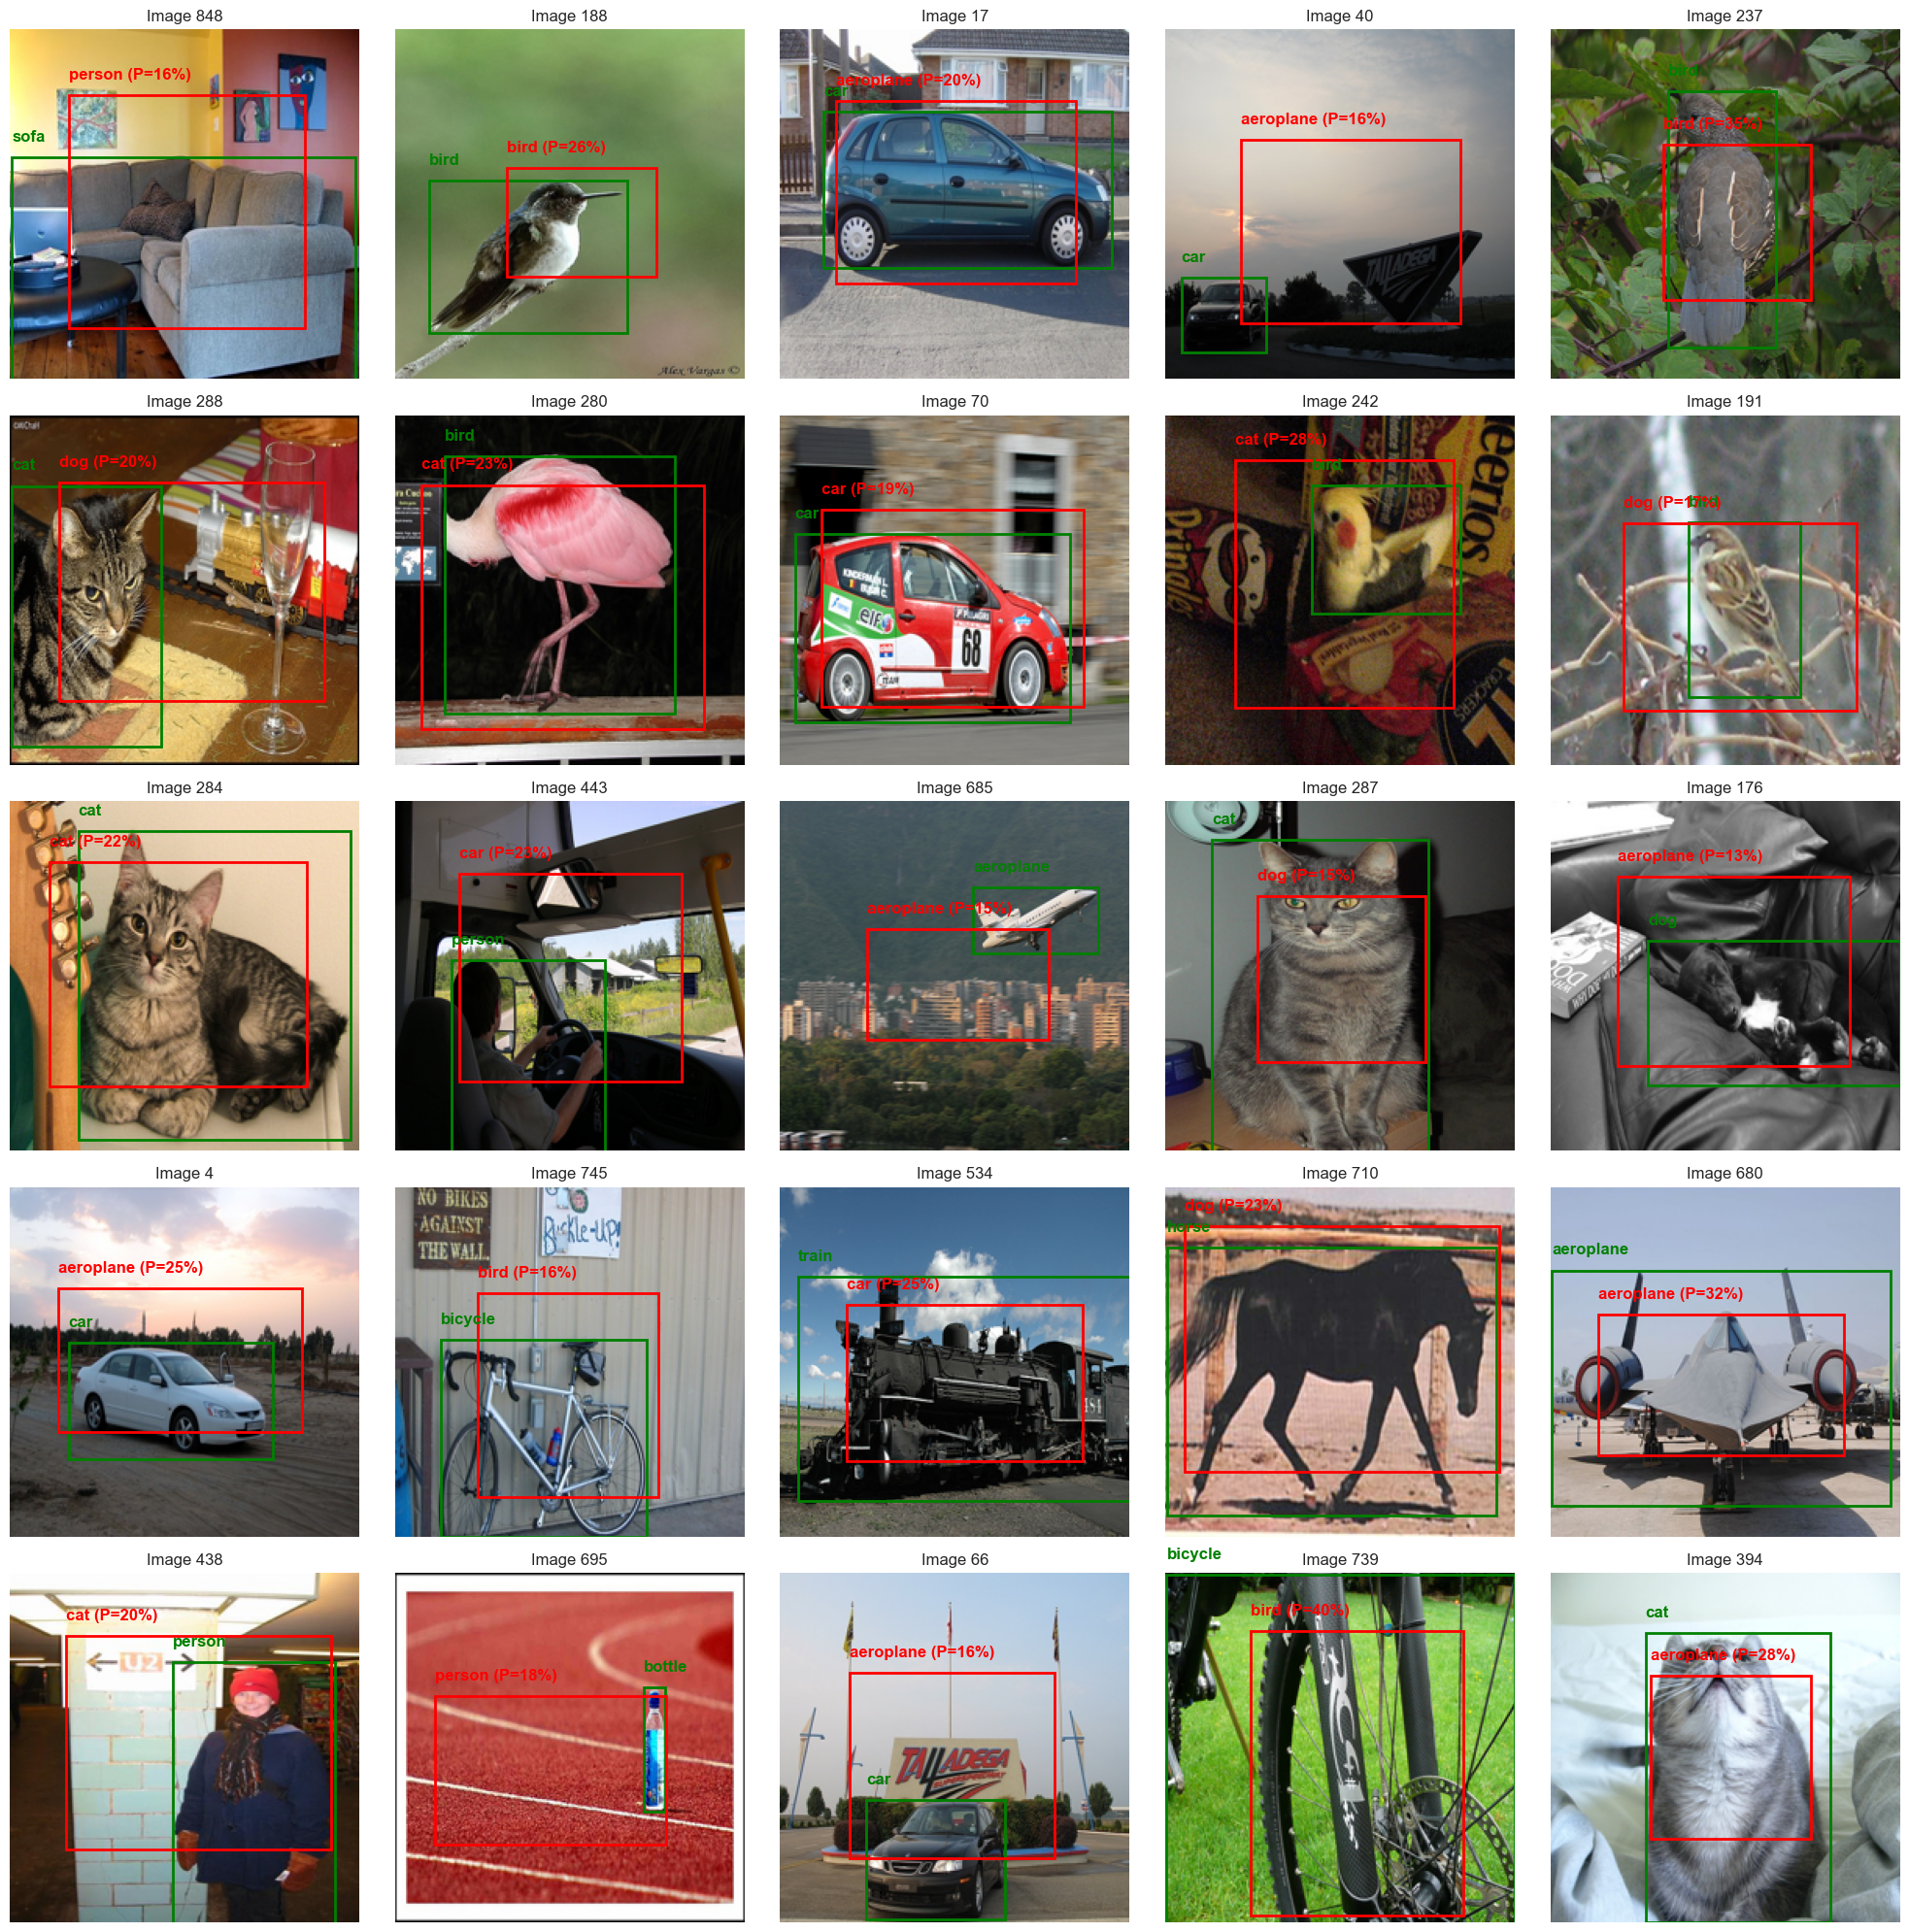

In [18]:
def plot_images_with_boxes_grid(image_indices, true_boxes, predicted_boxes, true_labels, predicted_labels, confidence_scores, images, results_dir, grid_size=5):
    # Ensure confidence_scores are floats
    confidence_scores = [float(score) for score in confidence_scores]

    # Set up the figure with a grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Get the image index
            img_index = image_indices[i]

            # Display the image
            img = images[img_index].permute(1, 2, 0).numpy()  # Convert from CHW to HWC format
            ax.imshow(img)

            # Plot true bounding box
            true_box = list(map(float, true_boxes[i].split(', ')))
            rect_true = plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1],
                                      linewidth=2, edgecolor='g', facecolor='none', label='True Box')
            ax.add_patch(rect_true)
            ax.text(true_box[0], true_box[1] - 10, true_labels[i], color='g', fontsize=12, fontweight='bold')

            # Plot predicted bounding box
            pred_box = list(map(float, predicted_boxes[i].split(', ')))
            rect_pred = plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1],
                                      linewidth=2, edgecolor='r', facecolor='none', label='Predicted Box')
            ax.add_patch(rect_pred)
            
            # Display predicted label with confidence score as an integer
            confidence_score = int(confidence_scores[i] * 100)  # Convert to percentage
            ax.text(pred_box[0], pred_box[1] - 10, f"{predicted_labels[i]} (P={confidence_score}%)", 
                    color='r', fontsize=12, fontweight='bold')

            ax.set_title(f'Image {img_index}')
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axes for any empty grid cells

    plt.tight_layout()

    # Save the figure as a PNG file in the specified results directory
    png_path = os.path.join(results_dir, 'bounding_boxes_plot.png')  # Specify the file path
    plt.savefig(png_path)  # Save the figure
    print(f'Saved plot to {png_path}')  # Confirm save location

    plt.show()

# Call the function to plot the images with bounding boxes in a grid and save the figure
plot_images_with_boxes_grid(image_indices, true_boxes, predicted_boxes, true_labels, predicted_labels, confidence_scores, all_images, results_dir)

- The `compute_metrics` function serves as a critical tool for evaluating the performance of a classification model, providing key metrics such as accuracy and F1 score that summarize how well the model predicts the target classes.
- By generating and visualizing confusion matrices, both in raw counts and as percentages, the function allows users to easily identify where the model excels and where it struggles, aiding in diagnosing specific areas for improvement.
- Additionally, the classification report provides a detailed breakdown of the model's performance for each class, making it an invaluable resource for stakeholders to understand the model's effectiveness and for data scientists to guide future refinements and iterations.

Total Accuracy: 0.2804
F1 Score: 0.2264
Saved confusion matrix to /Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_/confusion_matrix_counts.png


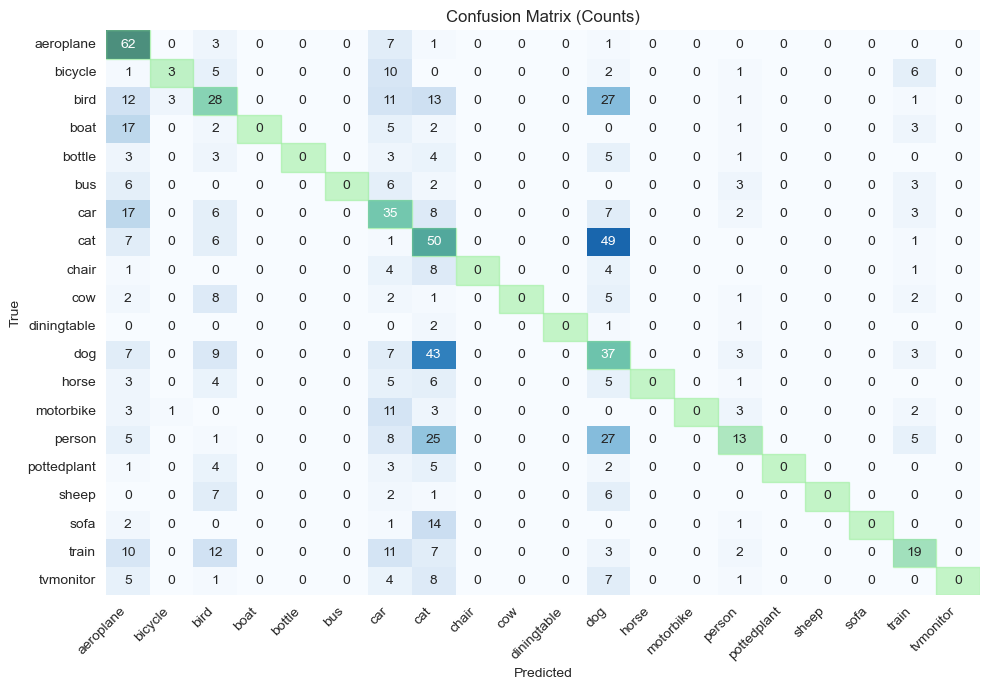

Saved confusion matrix to /Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_/confusion_matrix_normalized.png


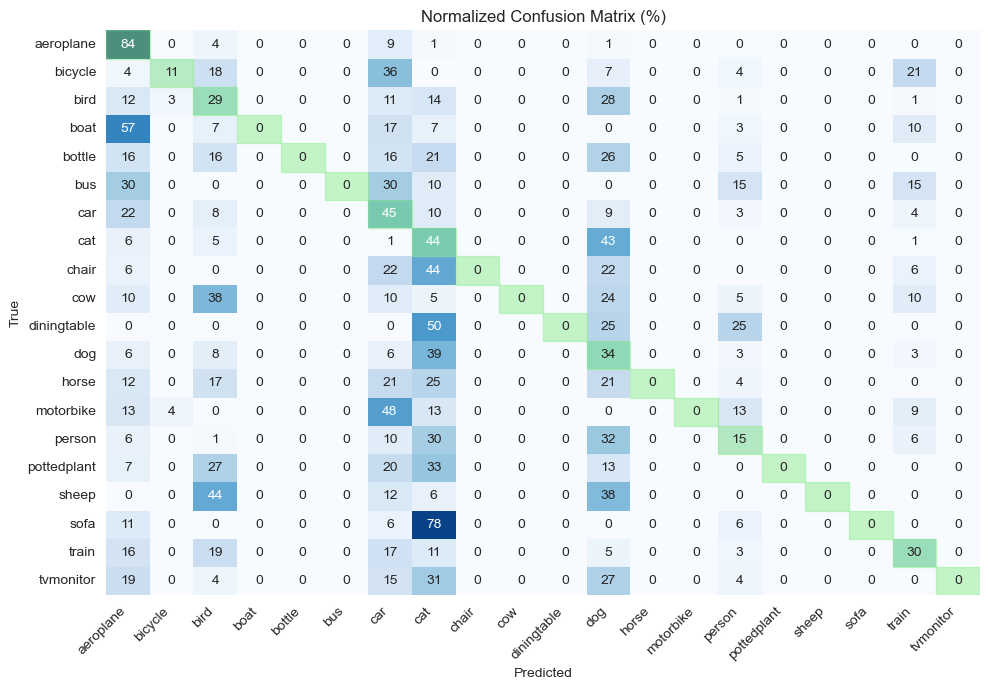

Saved classification report to /Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_/classification_report.csv

Classification Report:



precision    recall  f1-score     support
aeroplane      0.378049  0.837838  0.521008   74.000000
bicycle        0.428571  0.107143  0.171429   28.000000
bird           0.282828  0.291667  0.287179   96.000000
boat           0.000000  0.000000  0.000000   30.000000
bottle         0.000000  0.000000  0.000000   19.000000
bus            0.000000  0.000000  0.000000   20.000000
car            0.257353  0.448718  0.327103   78.000000
cat            0.246305  0.438596  0.315457  114.000000
chair          0.000000  0.000000  0.000000   18.000000
cow            0.000000  0.000000  0.000000   21.000000
diningtable    0.000000  0.000000  0.000000    4.000000
dog            0.196809  0.339450  0.249158  109.000000
horse          0.000000  0.000000  0.000000   24.000000
motorbike      0.000000  0.000000  0.000000   23.000000
person         0.371429  0.154762  0.218487   84.000000
pottedplant    0.000000  0.000000  0.000000   15.000000
sheep          0.000000  0.000000  0.000000   16.000000
sofa           0.000000  0.000000  0.000000   18.000000
train          0.387755  0.296875  0.336283   64.000000
tvmonitor      0.000000  0.000000  0.000000   26.000000
accuracy       0.280363  0.280363  0.280363    0.280363
macro avg      0.127455  0.145752  0.121305  881.000000
weighted avg   0.218783  0.280363  0.226372  881.000000

In [19]:
def compute_metrics(labels, predicted_labels, unique_labels, results_dir):
    """Compute and display evaluation metrics including accuracy, F1 score, and confusion matrices."""
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels, average='weighted')

    print(f'Total Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Compute the confusion matrix
    cm = confusion_matrix(labels, predicted_labels)

    def plot_confusion_matrix(cm, title, filename, normalize=False):
        """Helper function to plot and save confusion matrix."""
        plt.figure(figsize=(10, 7))
        heatmap = sns.heatmap(
            cm if not normalize else cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100,
            annot=True,
            fmt='d' if not normalize else '.0f',
            cmap='Blues',
            cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels
        )

        # Highlight the diagonal with light green shading
        for i in range(cm.shape[0]):
            heatmap.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='lightgreen', alpha=0.5))

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        # Save the confusion matrix as a PNG file
        cm_path = os.path.join(results_dir, filename)
        plt.savefig(cm_path)
        print(f'Saved confusion matrix to {cm_path}')  # Confirm save location
        plt.show()

    # Plot and save confusion matrices
    plot_confusion_matrix(cm, 'Confusion Matrix (Counts)', 'confusion_matrix_counts.png')
    plot_confusion_matrix(cm, 'Normalized Confusion Matrix (%)', 'confusion_matrix_normalized.png', normalize=True)

    # Generate and save classification report
    report = classification_report(labels, predicted_labels, target_names=unique_labels, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()

    report_path = os.path.join(results_dir, 'classification_report.csv')
    report_df.to_csv(report_path)
    print(f'Saved classification report to {report_path}')  # Confirm save location

    # Display the report
    print("\nClassification Report:\n")
    display(report_df)

# Example usage:
compute_metrics(all_labels, all_predicted, unique_labels, results_dir)

### Insights into Convolutional Neural Networks

- `visualize_feature_maps` function extracts and displays the feature maps generated by each convolutional layer of a CNN for a given input image, revealing how the model transforms the image and what features it detects at various stages.
- `visualize_filters` function showcases the filters of the first convolutional layer, enabling inspection of the learned weights and the patterns the model captures, which is crucial for interpreting model behavior and optimizing network design.

In [20]:
def visualize_feature_maps(model, image, maps_per_row=16):
    """
    Visualize the feature maps produced by a CNN model for a given image, organized with a specified number of feature maps per row.
    
    Args:
        model (nn.Module): The CNN model.
        image (torch.Tensor): The input image (C, H, W) format.
        maps_per_row (int): Number of feature maps to display per row (default is 16).
    """
    x = image.unsqueeze(0)  # Add a batch dimension
    
    # Extract convolutional layers
    conv_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d)]
    
    for idx, conv in enumerate(conv_layers):
        x = F.relu(conv(x))  # Pass the image through the convolutional layer
        
        feature_maps = x.detach().cpu().numpy()[0]  # Extract the feature maps
        num_feature_maps = feature_maps.shape[0]
        num_rows = (num_feature_maps + maps_per_row - 1) // maps_per_row  # Determine the number of rows

        fig, axes = plt.subplots(num_rows, maps_per_row, figsize=(20, num_rows * 2))

        for i in range(num_feature_maps):
            row = i // maps_per_row
            col = i % maps_per_row

            axes[row, col].imshow(feature_maps[i, :, :], cmap='gray')
            axes[row, col].axis('off')

        plt.suptitle(f"Conv Layer {idx+1} Feature Maps", fontsize=16)
        plt.tight_layout()
        plt.show()
        return fig
        
def visualize_filters(model, filters_per_row=16):
    """
    Visualizes the filters of the first convolutional layer in the CNN model.
    
    Args:
        model (nn.Module): The CNN model.
        filters_per_row (int): Number of filters to display per row.
    """
    # Get the weights of the first convolutional layer
    filters = model.conv1.weight.data  # Assuming the first layer is named conv1
    num_filters = filters.size(0)
    
    # Calculate grid size
    grid_size = int(np.ceil(num_filters / filters_per_row))
    
    # Set up the figure
    fig, axes = plt.subplots(grid_size, filters_per_row, figsize=(filters_per_row * 2, grid_size * 2))
    axes = axes.flatten()
    
    for i in range(num_filters):
        ax = axes[i]
        # Normalize the filter values to be between 0 and 1 for display
        f_min = filters[i].min()
        f_max = filters[i].max()
        filter_image = (filters[i] - f_min) / (f_max - f_min)
        
        ax.imshow(filter_image.permute(1, 2, 0).cpu().numpy())  # Convert from CHW to HWC
        ax.axis('off')
    
    # Hide remaining axes if there are fewer filters than grid size
    for i in range(num_filters, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    return fig

## 9. **Visualizing Feature Maps and Filters**

- This code visualizes the original image alongside the convolutional neural network (CNN) filters and feature maps, helping to understand how the model processes and interprets the input data.

- The original image is saved first, followed by plots of the CNN filters and the generated feature maps, providing insights into the learned representations at various layers of the model.

- By organizing the visualizations in a specified directory, the code facilitates easy access and further analysis of the model's performance and behavior.

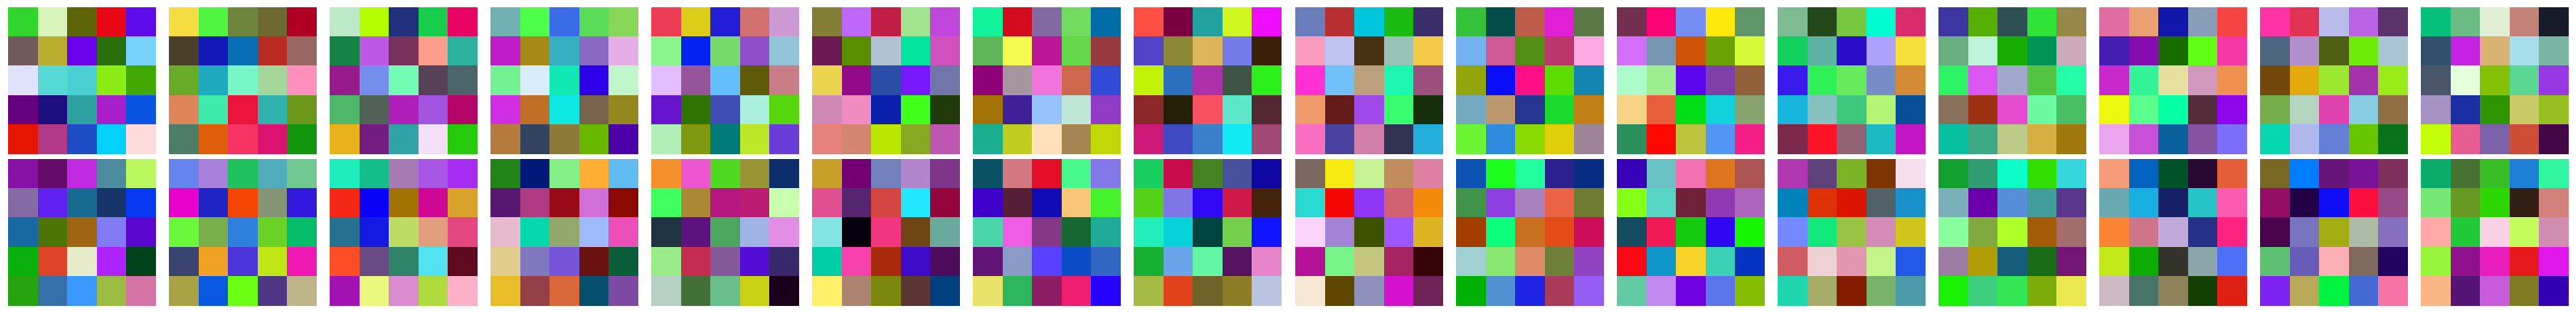

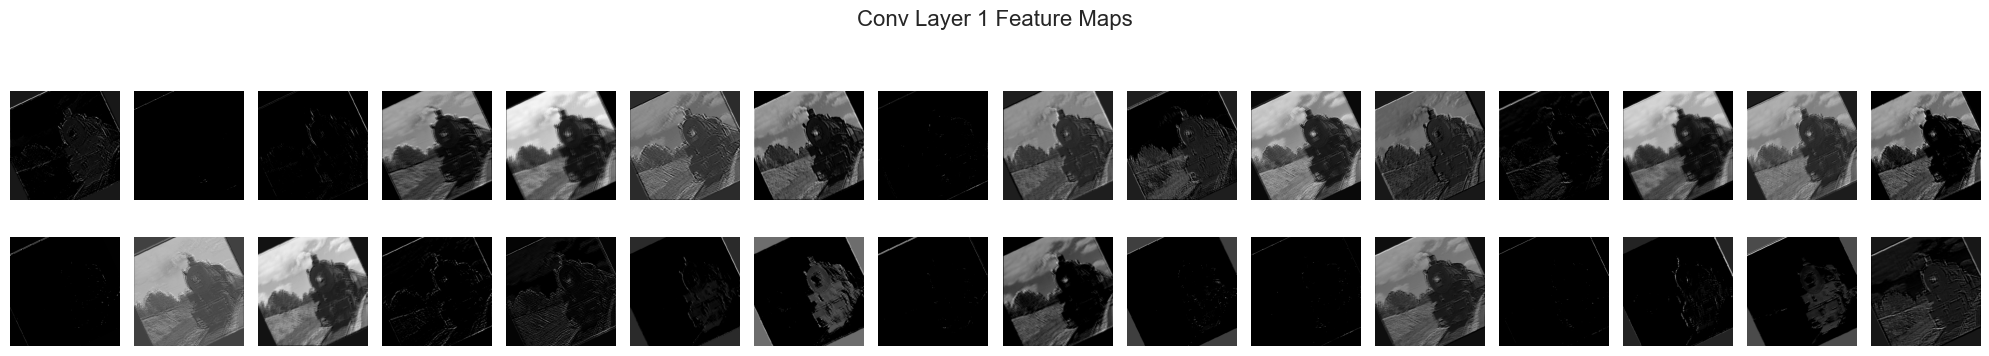

Saved plots to /Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_


In [28]:
def plot_image_and_filters(image, model, results_dir, filters_per_row=16, maps_per_row=16):
    """
    Visualize the original image, the CNN filters, and the feature maps together.

    Args:
        image (torch.Tensor): The input image in (C, H, W) format.
        model (nn.Module): The CNN model.
        results_dir (str): Directory to save the output plots.
        filters_per_row (int): Number of filters per row in the filter plot (default is 16).
        maps_per_row (int): Number of feature maps per row in the feature map plot (default is 16).
    """
    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)

    # Save the original image
    save_original_image(image, results_dir)

    # Save CNN filters plot
    save_cnn_filters(model, results_dir, filters_per_row)

    # Save feature maps plot
    save_feature_maps(model, image, results_dir, maps_per_row)

    print(f'Saved plots to {results_dir}')

def save_original_image(image, results_dir):
    """Save the original image to the specified directory."""
    plt.figure(figsize=(5, 5))
    plt.imshow(image.detach().permute(1, 2, 0).numpy())  # Detach and convert from CHW to HWC
    plt.title('Original Image')
    plt.axis('off')
    plt.savefig(os.path.join(results_dir, 'original_image.png'))
    plt.close()  # Close the figure to avoid display

def save_cnn_filters(model, results_dir, filters_per_row):
    """Save the CNN filters plot to the specified directory."""
    filter_fig = visualize_filters(model, filters_per_row=filters_per_row)
    filter_fig.savefig(os.path.join(results_dir, 'cnn_filters.png'))
    plt.close(filter_fig)  # Close the figure to avoid display

def save_feature_maps(model, image, results_dir, maps_per_row):
    """Save the feature maps plot to the specified directory."""
    feature_map_fig = visualize_feature_maps(model, image, maps_per_row=maps_per_row)
    feature_map_fig.savefig(os.path.join(results_dir, 'feature_maps.png'))
    plt.close(feature_map_fig)  # Close the figure to avoid display

# Example usage:
image = next(iter(train_loader))[0][0]  # Get a single image from the loader
results_dir = '/Users/michaelwalker/Desktop/Springboard/Sept 17 - online/pytorch_model_results/run_20241099_'  # Specify the directory to save results
plot_image_and_filters(image, model, results_dir, filters_per_row=16, maps_per_row=16)